### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Plotting helper function

In [2]:
def pretty_bar(data, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(15,12))
    sns.barplot(data.values, data.index)
    for i, v in enumerate(data.values):
        plt.text(0.8,i,v,color='k',fontsize=19)
    ylabel != None and plt.ylabel(ylabel, fontsize=12)
    xlabel != None and plt.xlabel(xlabel, fontsize=12)
    title != None and plt.title(title, fontsize=16)
    plt.show()

### Load data and look at missing values

In [3]:
train = pd.read_csv("../../data/shelter/train.csv")
test  = pd.read_csv("../../data/shelter/test.csv")

full = pd.concat([train, test])

print("train shape:", train.shape)
print("test shape:", test.shape)

pd.DataFrame({
    "Train Missing": train.isnull().sum().astype(int),
    "Test Missing": test.isnull().sum().astype(int)
})

train shape: (26729, 10)
test shape: (11456, 8)


,Test Missing,Train Missing
AgeuponOutcome,6.0,18.0
AnimalID,NaN,0.0
AnimalType,0.0,0.0
Breed,0.0,0.0
Color,0.0,0.0
DateTime,0.0,0.0
ID,0.0,NaN
Name,3225.0,7691.0
OutcomeSubtype,NaN,13612.0
OutcomeType,NaN,0.0


### First few rows of the train data

- I wonder why the name is included?  Is there anything we can do with it?  I don't think so, but missing names might indicate something (going off 5 data points, NaN is correlated with transfers)

- What use can I make out of OutcomeSubtype?  I wonder if the model would learn the subtypes easier, then I could map those to the OutcomeType

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### First few rows of the test data

In [5]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### Let's start off with the target column, 'OutcomeType'

Only 5 options are possible and it's very unlikely for the 'Died' outcome to happen

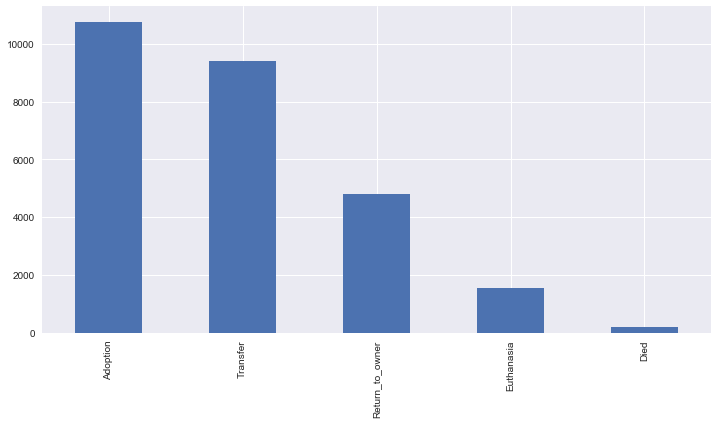

In [6]:
sns.set(rc={'figure.figsize':(12, 6)})

_ = train.OutcomeType.value_counts().plot(kind="bar")

### Create new column Outcome (OutcomeType + OutcomeSubtype)

In [7]:
train["Outcome"] = train.OutcomeType + " - " + train.OutcomeSubtype

print("Number of unique OutcomeSubtypes: ", len(train.OutcomeSubtype.unique()))
print("Number of unique Outcomes: ", len(train.Outcome.unique()))

Number of unique OutcomeSubtypes:  17
Number of unique Outcomes:  18


### Weird, I'd expect them to have the same number of unique values

Let's look at the two columns closer

After looking it's interesting to note that 'Barn' is an OutcomeSubtype for both 'Adoption' and 'Transfer'

In [8]:
# switched order so easier to compare
train["Outcome"] = train.OutcomeSubtype + " - " + train.OutcomeType

outcome_unique = train.Outcome.unique()
suboutcome_unique = train.OutcomeSubtype.unique()

for i in range(len(outcome_unique)):
    if i == len(suboutcome_unique):
        print("           ****", outcome_unique[i])
    else:
        print(suboutcome_unique[i], "****", outcome_unique[i])

nan **** nan
Suffering **** Suffering - Euthanasia
Foster **** Foster - Adoption
Partner **** Partner - Transfer
Offsite **** Offsite - Adoption
SCRP **** SCRP - Transfer
Aggressive **** Aggressive - Euthanasia
Behavior **** Behavior - Euthanasia
Rabies Risk **** Rabies Risk - Euthanasia
Medical **** Medical - Euthanasia
In Kennel **** In Kennel - Died
In Foster **** In Foster - Died
Barn **** Barn - Transfer
Court/Investigation **** Court/Investigation - Euthanasia
Enroute **** Enroute - Died
At Vet **** At Vet - Died
In Surgery **** In Surgery - Died
           **** Barn - Adoption


### Fill in missing values in OutcomeSubtypes

After the missing values are filled in, let's recreate the Column 'Outcome' again

In [9]:
train.OutcomeSubtype = train.OutcomeSubtype.fillna("NaN")
train["Outcome"] = train.OutcomeType + " - " + train.OutcomeSubtype

print("Number of unique OutcomeSubtypes: ", len(train.OutcomeSubtype.unique()))
print("Number of unique Outcomes: ", len(train.Outcome.unique()))

Number of unique OutcomeSubtypes:  17
Number of unique Outcomes:  22


### All the possible outcomes

Very interesting, remember how Barn is a subtype shared between 'Adoption' and 'Transfer'?  Well there is only one example for each!

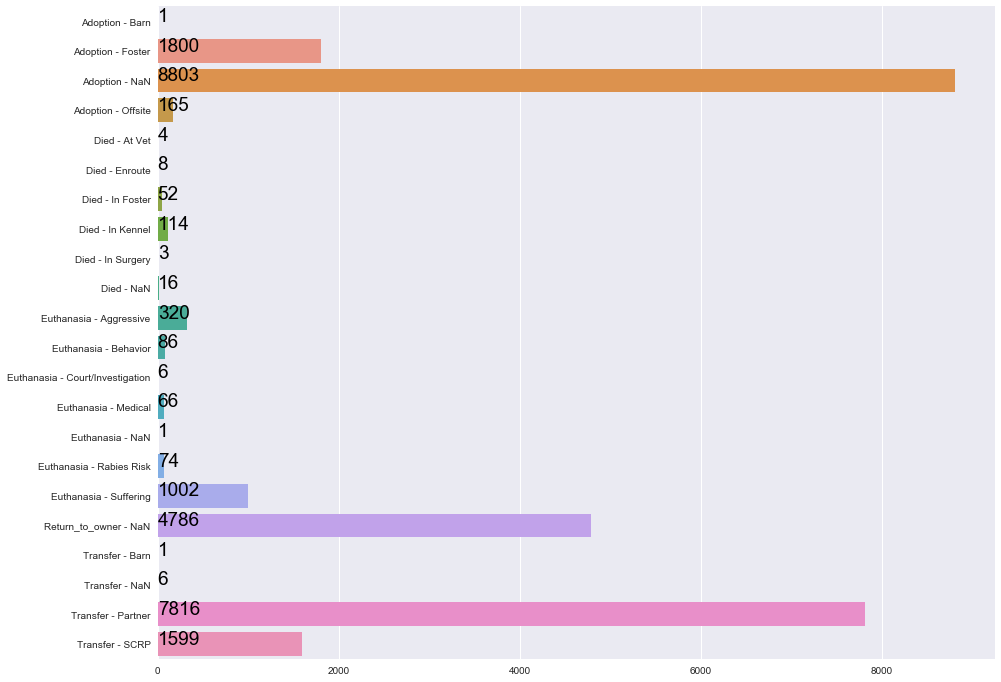

In [10]:
pretty_bar(train.Outcome.value_counts().sort_index())

### Difference animal types

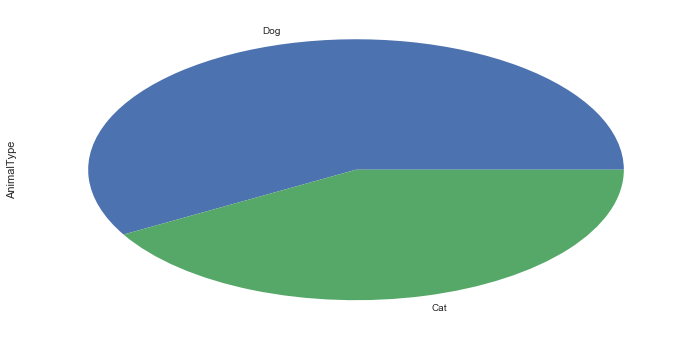

In [11]:
_ = full.AnimalType.value_counts().plot(kind="pie")

### SexuponOutcome

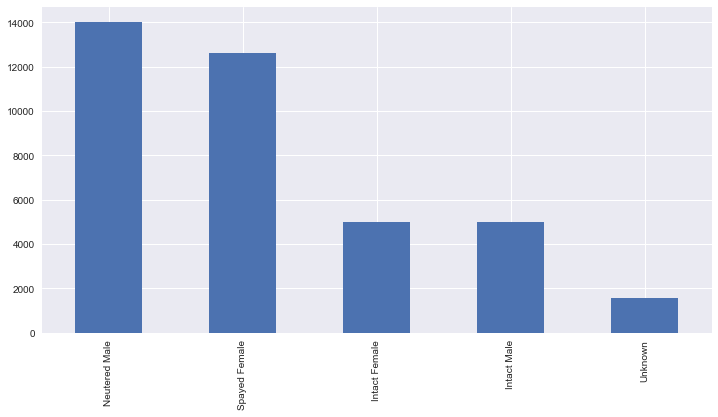

In [12]:
_ = full.SexuponOutcome.value_counts().plot(kind="bar")

### Breed and Color columns

In [19]:
print("All breeds contained in test data are in train data?")
print(set(test.Breed.unique()) <= set(train.Breed.unique()))
print()
print("All colors contained in test data are in train data?")
print(set(test.Color.unique()) <= set(train.Color.unique()))
print()
print("Num unique breeds", len(full.Breed.unique()))
print("Num unique colors", len(full.Color.unique()))

All breeds contained in test data are in train data?
False

All colors contained in test data are in train data?
False

Num unique breeds 1678
Num unique colors 411
